<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выбираем-лучшую-модель" data-toc-modified-id="Выбираем-лучшую-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выбираем лучшую модель</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Заказчик собрал исторические данные о заказах такси в аэропортах. Чтобы правильно распределить количество водителей и увеличить их во время пиковой нагрузки необходимо построить модель, которая спрогнозирует количество заказов. 

**Цель работы** - предсказать количество заказов такси на следующий час

По требованию заказчика *значение метрики RMSE* на тестовой выборке должно быть не больше 48.

Нам предоставлен временной ряд, собранный в датасет **taxi**/ Количество заказов находится в столбце `num_orders`- «число заказов».

**Задачи**:
- импортировать необходимые библиотеки
- Загрузить данные
- Подготовить данный. Выполнить их ресемплирование по одному часу
- Проанализировать данные
- Обучить несколько моделей с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных
- Проверить данные на тестовой выборке и сделать выводы

## Подготовка

### Импорт библиотек 

In [1]:
!pip install phik -q
!pip install catboost -q
!pip install lightgbm==3.3.5 -q
!pip install skorch -q

In [2]:
import itertools
import os
import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler 

from phik.report import correlation_report, plot_correlation_matrix

from statsmodels.tsa.seasonal import seasonal_decompose

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.utils.data import DataLoader, TensorDataset


In [3]:
RANDOM_STATE = 42

### Загрузка данных

In [4]:
file_path = 'C:/Users/79533/Desktop/yandex_practicum/python/datasets/taxi.csv'
print("Путь существует:", os.path.exists(file_path))

Путь существует: False


In [5]:
try:
    taxi = pd.read_csv('C:/Users/79533/Desktop/yandex_practicum/python/datasets/taxi.csv')

except:

    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')


Смотрим данные

In [6]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Интервал равен 10 мин

### Подготовка данных

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет

Столбец datetime переведем в тип datetime и установим индексом

In [8]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [9]:
taxi.set_index(taxi['datetime'], inplace=True)
taxi.drop(columns='datetime', inplace=True)

In [10]:
taxi.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


In [11]:
taxi_0 = taxi.copy()

Сделаем ресемплирование по одному часу, посчитаем сумму заказов в каждом часу

In [12]:
taxi = taxi.resample('1H').sum()

## Анализ данных

In [13]:
taxi.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Среднее отличается от медианного. Должны быть часы с очень большой загрузкой - часы пик или выбросы.надо разобраться

In [14]:
taxi.query('num_orders==0')

,num_orders
datetime,
2018-04-06 06:00:00,0


Минимальное значение 0 около 6 утра - это нормально. В этот период времени (5-6 утра) количество заказов минимально

In [15]:
taxi.isna().sum()

num_orders    0
dtype: int64

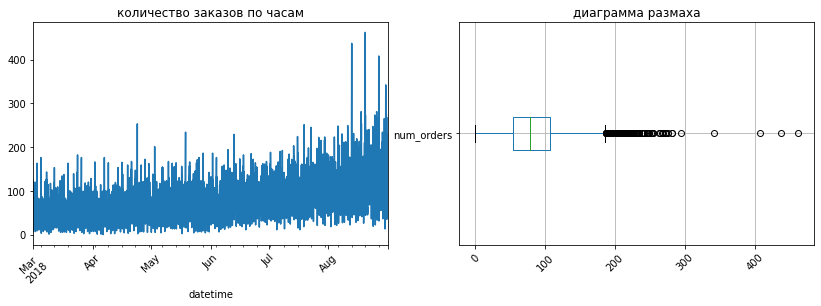

In [16]:
plt.figure(figsize=(14,9))
plt.subplot(2, 2, 1)
taxi['num_orders'].plot();
plt.title('количество заказов по часам')
plt.xticks(rotation=45);

plt.subplot(2, 2, 2)
taxi.boxplot(vert=False);
plt.xticks(rotation=45);
plt.title('диаграмма размаха')
plt.show()

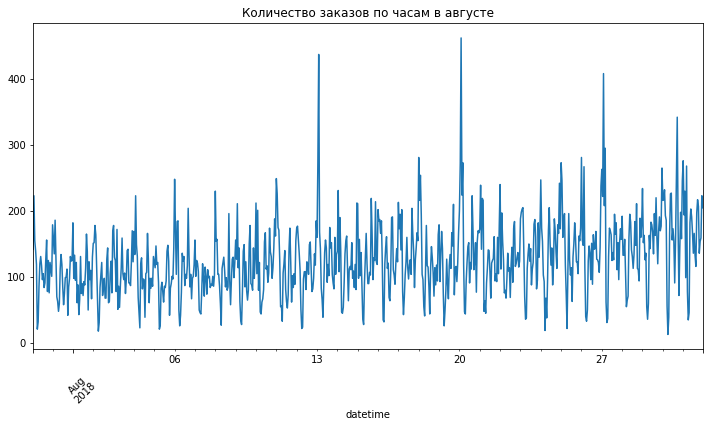

In [17]:
plt.figure(figsize=(12,6))

taxi[taxi.index > "2018-07-30 00:00:00"]['num_orders'].plot()
plt.title('Количество заказов по часам в августе')
plt.xticks(rotation=45)
plt.show()

мы видим, что больше 300 заказов-это редкость. Такое число возможно, но мы хотим модель, улавливающую общие закономерности для ежедневной оценки нагрузки на сервис. Эти 4 значения могут ухудшить обощающую способность модели, однако они имеют некоторую периодичность(примерно раз в неделю). 

В итоге решили их удалить

Мы видим, что спрос на серсис растет с течением времени. Оценим тренды и сезонность 

In [18]:
decomposed = seasonal_decompose(taxi) 

In [19]:
taxi['seasonal'] = decomposed.seasonal

In [20]:
taxi

,num_orders,seasonal
datetime,,
2018-03-01 00:00:00,124,60.248112
2018-03-01 01:00:00,85,20.177074
2018-03-01 02:00:00,71,28.982743
2018-03-01 03:00:00,66,17.885407
2018-03-01 04:00:00,43,2.791145
...,...,...
2018-08-31 19:00:00,136,-7.124270
2018-08-31 20:00:00,154,-2.696560
2018-08-31 21:00:00,159,10.670243


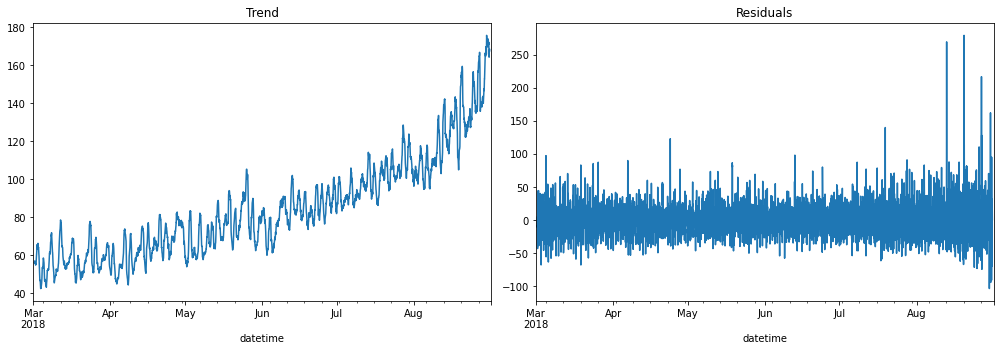

In [21]:
plt.figure(figsize=(14,9))
plt.subplot(2, 2, 1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

plt.subplot(2, 2, 2)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [22]:
seasonal = decomposed.seasonal

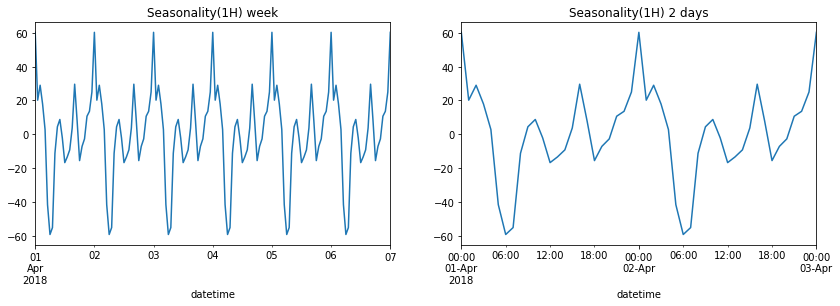

In [23]:
plt.figure(figsize=(14,9))
plt.subplot(2, 2, 1)
seasonal['2018-04-01 00:00:00':'2018-04-07 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality(1H) week');

plt.subplot(2, 2, 2)
seasonal['2018-04-01 00:00:00':'2018-04-03 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality(1H) 2 days');

**trend**
Мы видим плавное увеличение количества заказов в течение года

**seasonality**
Посмотрели график сезонности за неделю. Мы видим повторяющийся рисунок: наблюдается цикл подъемов и спадов в определенные часы (максимальное количество заказов около 0 часов ночи, резкий спад после 3 утра. Практически нулевое количество заказов около 6 утра. Подъем к 9, небольшой спад с 12 до 15, затем снова подъем. Небольшой спад около 6 вечера и плавный подъем до 0 часов ночи до максимального значения).
**residuals**
Остатки в основном колеблются вокруг нуля, значит тренд и сезонность смогли частично описать структуру данных.
 Наблюдается увеличение дисперсии ближе к концу, остатки становятся более "разбросанными" — это может быть признаком:
- неучтённой структуры или изменений в поведении потребления;
- наличия выбросов или увеличения нестабильности в эти месяцы.

Видно несколько высоких пиков, которые выходят за общий диапазон. Эти скачки могут быть:
- случайным шумом;
- эффектом праздников или аномальных событий (например, аномальная жара или нагрузка на сеть).


Примем эти скачки за эффект праздников или  аномалий (например жара и ливень), не будем принимать их за выбросы потому что данные вполне реальны

In [24]:
taxi_day = taxi_0.resample('1D').sum()
decomposed_day = seasonal_decompose(taxi_day) 
seasonal_day = decomposed_day.seasonal

In [25]:
seasonal_day

datetime
2018-03-01     13.568634
2018-03-02    137.511491
2018-03-03     24.505777
2018-03-04   -106.092025
2018-03-05    149.045338
                 ...    
2018-08-27    149.045338
2018-08-28   -182.410706
2018-08-29    -36.128509
2018-08-30     13.568634
2018-08-31    137.511491
Freq: D, Name: seasonal, Length: 184, dtype: float64

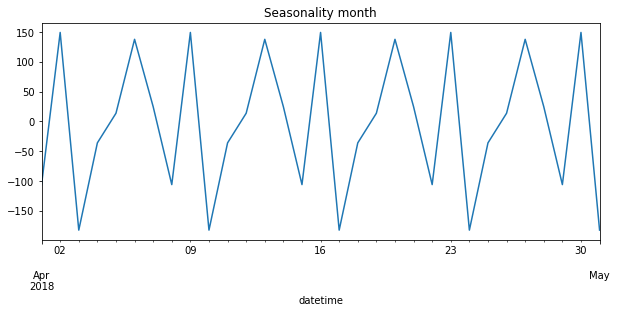

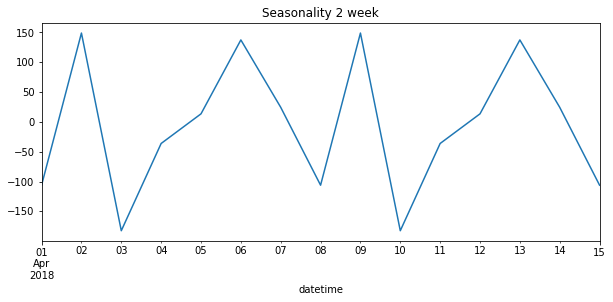

In [26]:
plt.figure(figsize=(10,4))
seasonal_day['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Seasonality month');

plt.figure(figsize=(10,4))
seasonal_day['2018-04-01':'2018-04-15'].plot(ax=plt.gca())
plt.title('Seasonality 2 week');

По неделям сезонность тоже прослеживается. Мы видим, что количество заказов зависит от дня недели:

2 апр 2018 - **пн - пик**
3 апреля 2018 - **вт - спад** кол-ва заказов.
постепенно растет
6 апр 2018 - **пт - пик**
8 апр 2018 - **вскр - спад**

9 апр 2018- **пн - пик**
10 апр 2018 - **вт - спад**
постепенно растет
13 апр 2018 - **пт- пик**
15 апр 2018 - **вскр - спад**

16 апр 2018 - **пн - пик**
17 апр 2018 - **вт - спад**
постепенно растет
20 апр 2018 - **пт- пик**
и т.д.

возможно это зависит от рейсов прилетающих в эти дни в аэропорт (очень часто есть рейсы, которые леают не каждый день, а в определенные дни недели)

Можно заключить, что день недели - важная фича

## Обучение

Сначала разделим на выборки, а потом добавим новые признаки. Мы делаем в таком порядке, чтобы избежать утечки при создании лаговых признаков

In [27]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

Добавим дополнительные признаки : час, день, день недели, месяц, лаговые функции (например, lag_1 — сколько заказов было час назад, lag_24 — сутки назад) скользящее среднее. 

Мы хотим вызывать только определенные лаги, а не все подряд (час,два,три назад и сутки назад), в функции зададим список конкретных лагов (это может быть полезно-знать какое количество было ровно сутки назад. Например в будни ситуация может повторяться, однако в выходные она будет другой. Поэтому признак день недели нам тоже необходим).

In [28]:
def make_features(data, lags, rolling_mean_size):
    data = data.copy()
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # Добавим только указанные лаги
    for lag in lags:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_mean_24'] = data['num_orders'].shift().rolling(24).mean()
    return data

Мы хотим отловить краткосрочные тренды  например, изменения количества заказов за последние несколько часов). Возьмем окно скользящего среднего 4 (будем сглаживать колебания за 4 часа).

и посмотрим большее сглаживаение, например за сутки. Это не одно и то же, что лаговый признак за 24 часа, т.к 	rolling(window=24) показывает общую тенденцию, сглаживает шум, а lag 24 показывает точечную зависимость от вчерашнего часа 

In [29]:
lags = [1, 2, 3, 24]
rolling_mean_size = 4

train_1 = make_features(train, lags=lags, rolling_mean_size=rolling_mean_size).dropna()
test_1 = make_features(test, lags=lags, rolling_mean_size=rolling_mean_size).dropna()

In [30]:
train_1.head(5)

,num_orders,seasonal,hour,dayofweek,lag_1,lag_2,lag_3,lag_24,rolling_mean,rolling_mean_24
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,60.248112,0,4,58.0,113.0,66.0,124.0,74.50,56.833333
2018-03-02 01:00:00,120,20.177074,1,4,90.0,58.0,113.0,85.0,81.75,55.416667
2018-03-02 02:00:00,75,28.982743,2,4,120.0,90.0,58.0,71.0,95.25,56.875000
2018-03-02 03:00:00,64,17.885407,3,4,75.0,120.0,90.0,66.0,85.75,57.041667
2018-03-02 04:00:00,20,2.791145,4,4,64.0,75.0,120.0,43.0,87.25,56.958333


Несмотря на то, что все признаки выражены в числах, за категориальные примем признаки:
*hour* -  часы идут по кругу,поэтому  hour=2 и hour=6 — это не обязательно "ближе", чем 2 и 22.
*dayofweek* - 7 категорий

Посмотрим корреляцию признаков

In [31]:
num_col = ['num_orders','lag_1','lag_2','lag_3','lag_24','rolling_mean', 'rolling_mean_24']

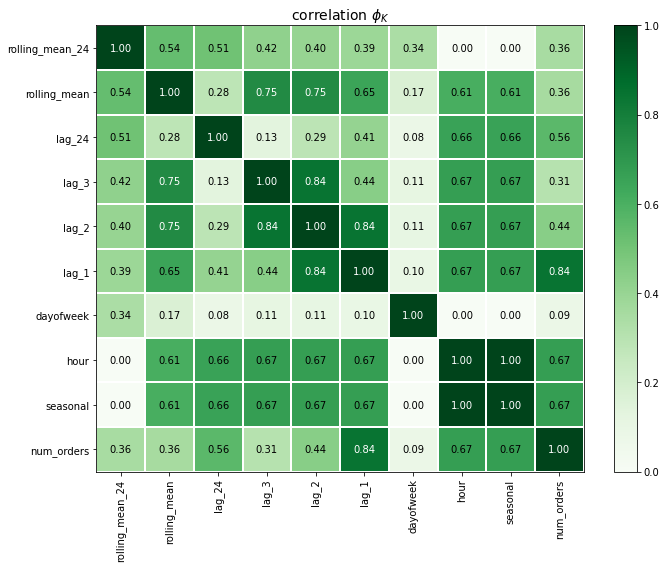

In [32]:
phik_overview = train_1.phik_matrix(interval_cols = num_col)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

На первый взгляд кажется, что hour и seasonal отражают одно и то же — суточную сезонность, но они не идентичны и несут разную информацию, особенно с точки зрения модели. Между ними может быть сильная корреляция, особенно при регулярной суточной сезонности. Но это не гарантирует мультиколлинеарность в том виде, который вредит модели. Особенно для нейронных сетей, которые лучше переносят коррелированные признаки.


hour (час)- жёсткий категориальный/циклический признак, он принимает значение от 0 до 23. Он одинаков из дня в день, то есть: 8 утра 1 января = 8 утра 2 января по признаку hour.
seasonal (из decomposed.seasonal) - гладкая, числовая компонента, извлечённая из временного ряда, учитывает контекст временного ряда и может меняться со временем, даже в одно и то же "часовое окно".
Например, если в одни дни пики в 8 утра выражены сильнее, seasonal это отразит, а hour — нет

dayofweek оставим, потому что матрица корреляций может не учитывать сложные взаимодействия признаков.Phik — это парный показатель. Он оценивает связь между двумя признаками, но не учитывает многомерные взаимодействия (тройки и более признаков одновременно).

In [33]:
y_train_1 = train_1['num_orders']
X_train_1 = train_1.drop(columns='num_orders')

y_test_1 = test_1['num_orders']
X_test_1 = test_1.drop(columns='num_orders')

Создаем разные модели

1) **Catboost**

In [34]:
cat_features = ['hour', 'dayofweek']

In [35]:
model_cat = CatBoostRegressor(
    loss_function='RMSE',
    verbose=0,
    random_seed=RANDOM_STATE,
    l2_leaf_reg=3)

param_dist = {
    'learning_rate': [0.05, 0.01, 0.03, 0.05],
    'depth': [3, 4, 5, 6],
    'iterations': [50, 100, 200, 300]}

# Time-aware кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)


random_search_cat = RandomizedSearchCV(
    estimator=model_cat,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)


# учтем время работы модели
start_time_cat = time.time()

random_search_cat.fit(
    X_train_1, y_train_1,
    cat_features=cat_features,
    eval_set=[(X_train_1.iloc[-int(len(X_train_1)*0.1):], y_train_1.iloc[-int(len(y_train_1)*0.1):])],
    early_stopping_rounds=30,
    use_best_model=True
)


elapsed_time_cat = time.time()- start_time_cat

# Результаты
print("Лучшие параметры:", random_search_cat.best_params_) 
print("среднее RMSE по CV:", round(-random_search_cat.best_score_, 3))
print("Время обучения: {:.2f} секунд".format(elapsed_time_cat))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'learning_rate': 0.05, 'iterations': 300, 'depth': 3}
среднее RMSE по CV: 25.944
Время обучения: 66.30 секунд


2) **lightboost**

не кодируем категориальные признаки, т.к. они в числах

In [36]:
model_lgb = LGBMRegressor(reg_alpha=0.1,
                          reg_lambda=1.0,
                          verbose=-1,         
                          random_state=42)

param_dist = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [ 4, 5, 6],
    'n_estimators': [200, 300],
    'num_leaves': [6, 8]}

# Time-aware кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)


random_search_lgb = RandomizedSearchCV(
    estimator=model_lgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

fit_params = {
    'eval_set': [(X_train_1.iloc[-int(len(X_train_1) * 0.1):],
                  y_train_1.iloc[-int(len(y_train_1) * 0.1):])],
    'callbacks': [early_stopping(stopping_rounds=30)]
}

#время обучения модели
start_time_lgb = time.time()




random_search_lgb.fit(X_train_1, y_train_1, **fit_params)

elapsed_time_lgb = time.time() - start_time_lgb

# Результаты
print("Лучшие параметры:", random_search_lgb.best_params_)
print("Лучшее среднее RMSE по CV:", round(-random_search_lgb.best_score_, 3))
print(f"Время обучения: {elapsed_time_lgb:.2f} секунд")

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[156]	valid_0's l2: 2115.81
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 1515.34
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[295]	valid_0's l2: 1198.83
Did not meet early stopping. Best iteration is:
[277]	valid_0's l2: 1198.01
Did not meet early stopping. Best iterat

**3) сделаем модель полносвязной нейросети**

Для нейросети такие категориальные признаки как 'hour'и  'dayofweek' лучше закодировать с помощью cyclical encoding. Для нейросетей важно, чтобы отношения были геометрически «правильными», т.е. расстояния между значениями имели смысл.Cyclical encoding (sin/cos) позволяет нейросети видеть «близость» например 23 и 0 часов

Создаем свой энкодер для циклического кодирования, который потом встроим в пайплайн

In [37]:
def cyclical_transform(df):
    df = df.copy()
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df.drop(['hour', 'dayofweek'], axis=1)

cyclical_encoder = FunctionTransformer(cyclical_transform)

In [38]:
#  препроцессинг
preprocessing = Pipeline([
    ('cyclic', cyclical_encoder),
    ('scale', StandardScaler())
])

# определяем PyTorch модель
class TaxiNet(nn.Module):
    def __init__(self, input_size, hidden1=100, hidden2=32, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.LeakyReLU()
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.relu2 = nn.SiLU()
        
        self.fc3 = nn.Linear(hidden2, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu2(x)

        x = self.fc3(x)
        return x.squeeze(-1)


# RMSE Loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    def forward(self, preds, targets):
        return torch.sqrt(self.mse(preds, targets) + 1e-8)

    
X_temp = preprocessing.fit_transform(X_train_1)
input_size = X_temp.shape[1]    

net = NeuralNetRegressor(
    TaxiNet,
    module__input_size=input_size,
    criterion=RMSELoss,
    max_epochs=30,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=0,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    iterator_train__shuffle=False
)

# 5. Общий pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('regressor', net)
])

#  Масштабируем целевую переменную 
full_model = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

param_dist = {
    'regressor__regressor__module__dropout_rate': [0.0, 0.2, 0.3],
    'regressor__regressor__lr': [0.001, 0.0005, 0.0001],
    'regressor__regressor__batch_size': [32, 64]
}

tscv = TimeSeriesSplit(n_splits=3)

random_search_net = RandomizedSearchCV(
    full_model,
    param_distributions=param_dist,
    n_iter=18,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

X_train_1 = X_train_1.astype(np.float32)
y_train_1 = y_train_1.astype(np.float32)

#  замеряем время
start_time = time.time()
random_search_net.fit(X_train_1, y_train_1)
elapsed_time_net = time.time() - start_time


Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [39]:
print("Лучшие параметры:", random_search_net.best_params_)
print("Среднее RMSE по CV:", round(-random_search_net.best_score_, 3))
print(f"Время обучения: {elapsed_time_net:.2f} секунд")

Лучшие параметры: {'regressor__regressor__module__dropout_rate': 0.3, 'regressor__regressor__lr': 0.001, 'regressor__regressor__batch_size': 32}
Среднее RMSE по CV: 24.456
Время обучения: 442.18 секунд


### Выбираем лучшую модель

In [40]:
comparison_table = pd.DataFrame([
    {
        'Модель': 'CatBoost',
        'среднее RMSE по CV':  round(-random_search_cat.best_score_, 3),
        "Лучшие параметры:": str(random_search_cat.best_params_),
        "Время обучения: {:.2f} секунд": str(round(elapsed_time_cat,2))
    },
    {
        'Модель': 'LightGBM',
        'среднее RMSE по CV':   round(-random_search_lgb.best_score_, 3),
        "Лучшие параметры:": str (random_search_lgb.best_params_),
       "Время обучения: {:.2f} секунд": str(round(elapsed_time_lgb,2))
    },
        {
        'Модель': 'Нейросеть',
        'среднее RMSE по CV':   round(-random_search_net.best_score_, 3),
        "Лучшие параметры:": str (random_search_net.best_params_),
       "Время обучения: {:.2f} секунд": str(round(elapsed_time_net,2))
    }

])

display(comparison_table)

,Модель,среднее RMSE по CV,Лучшие параметры:,Время обучения: {:.2f} секунд
0,CatBoost,25.944,"{'learning_rate': 0.05, 'iterations': 300, 'de...",66.3
1,LightGBM,25.564,"{'num_leaves': 6, 'n_estimators': 300, 'max_de...",62.12
2,Нейросеть,24.456,{'regressor__regressor__module__dropout_rate':...,442.18


На кросс-валидации все модели получили близкое значение RMSE. Чуть хуже справилась нейросеть (дольше и скоринг выше)

В качестве лучшей модели выберем нейросеть. Она показывает лучший скоринг,хоть и работает дольше

## Тестирование

Тест стоит провести только на лучшей выбранной модели, но ради интереса посмотрим на всех. Убедимся какая модель по факту справилась лучше

**Тест на нейросети**

In [41]:
X_test_1 = X_test_1.astype(np.float32)
y_test_1 = y_test_1.astype(np.float32)

y_pred = random_search_net.predict(X_test_1)

rmse_test = mean_squared_error(y_test_1, y_pred, squared=False)
print(f"Test RMSE: {rmse_test:.3f}")

Test RMSE: 39.179


## Вывод

В ходе проведенного исследования были выполнены следующие этапы:
1) **импортированы необходимые библиотеки**

2) выполнена **загрузка данных**

3) **знакомство с данными и подготовка их для анализа**: оценка типов данных,пропусков, выполнено ресемплирование по часу (с подсчетом суммы заказов в каждом часу)

4) в **анализе данных** посмотрели описательную статистику. Увидели значимое расхождение медианного и среднего, что может указывать на выбросы. Убедились в отсутствии пропусков. Построили гистограмму распределения количества заказов по часам за весь период временного ряда и боксплот. Определили потенциальные выбросы, однако для того, чтобы утверждать точнее исследовали тренд, сезонность и остатки. Наши предполагаемые выбросы попали в остатки - что соответствует шуму, выбросам или редким случаям (например праздничные дни).  
 Также было отмечено увеличение тренда и отсутствие сезонности
 
5) приступили к **обучению моделей**. Для этого проекта в качестве моделей были выбраны катбуст, лайтбуст и построена полносвязная нейросеть. 
 Выделили тестовую выборку размером 10% от всех данных. Т.к. мы работали с временным рядом, при разделении выборок указали параметр shuffle=False. 
 *Добавили дополнительные признаки* : час, день, день недели,  лаговые функции (например, lag_1 — сколько заказов было час назад, lag_24 — сутки назад), скользящее среднее(т.к.мы хотим отловить краткосрочные тренды  размер окна взяли- 4)
Признаки hour, dayofweek приняли за категориальные, т.к. они цикличны
Затем посмотрели корреляцию признаков с помощью phik-матрицы.

Обучили три модели с подбором гиперпараметров и кросс-валидацией на трех фолдах. Для модели catboost использовали внутренний кодировщик категориальных признаков, а для нейросети сделали cyclical encoding (sin/cos), т.к он лучше помогает видеть нейросети «близость» например 23 и 0 часов (для лучшей работы нейросети важно чтобы отношения были геометрически «правильными», т.е. расстояния между значениями имели смысл). Также замерили время обучения модели. С помощью сравнительной таблицы выбрали лучшую модель (нейросеть) и посчитали предикт на тесте. Наше метрика RMSE вписалась в критерии проекта (не более 48)

**Заключение**: в результате работы была создана модель катбуста, на основе временного ряда определяющая количество заказов на следующий час.